# Raport nr 1, Symulacje komputerowe

###  Emil Olszewski, Artur Sadurski  
---  

**Zadanie 1**  
Generator liczb pseudolosowych

In [170]:
using Plots
using Distributions
using HypothesisTests
using BenchmarkTools
using BenchmarkPlots
using Statistics
using KernelDensity
using SpecialFunctions

Poniżej znajduje się implementacja generatora MRG32k3a liczb pseudolosowych z rozkładu jednostajnego na odcinku [0, 1]

In [ ]:
function MRG32k3a(
    size, 
    seedx = [1822406609, 1153072917, 1254937013], 
    seedy = [2311980605, 7239483046, 2394024690]
    )

    result = Vector{Float64}(undef, size)

    m1 = 2^32 - 209
    m2 = 2^32 - 22853

    for i in 1:size

        x = mod((1403580seedx[2] - 810728seedx[3]), m1)
        y = mod((527612seedy[1] - 1370589seedy[3]), m2)

        result[i] = ifelse(x > y, (x - y) / (m1 + 1), (x - y + m1) / (m1 + 1))

        # Do generowania realizacji zmiennej losowej potrzebujemy tylko 3 ostatnich 
        # wartości x i y. Tym samym seedx i seedy możemy traktować jako kolejkę, w
        # każdej iteracji odrzucając wartości z końca i dodanie nowo obliczonych 
        # wartości do początku. 
        
        pop!(seedx); pop!(seedy)
        pushfirst!(seedx, x); pushfirst!(seedy, y)

    end

    return result

end

In [ ]:
UNIFORM_SAMPLE_SIZE = 10_000
mrg_samples = MRG32k3a(UNIFORM_SAMPLE_SIZE)
scatter(mrg_samples, markersize=1, color=:purple3, legend=nothing, title="Realizacje algorytmu MRG32k3a")

Jak widać liczby generowane przez *MRG32k3a* rozkładają się w miarę równomiernie na odcinku [0, 1]. Skłania nas to do stwierdzenia, że pochodzą one z rozkładu U(0, 1). Aby potwierdzić tą hipotezę, wykonamy histogram generowanych wartości.

In [ ]:
histogram(mrg_samples, color=:purple3, label="Rozkład otrzymanych wartości", normalize=:pdf, legend=:outerbottom)
plot!(x -> (0 < x < 1), lw=5, color=:gold, label="Gęstość rozkładu U(0, 1)")

Powyższy histogram dobrze obrazuje jednostajność generowanych wartości. Nie dowodzi to jednak niezależności. Sprawdzimy teraz kilka cech, które powinny charakteryzować ciąg niezależnych zmiennych losowych. 

* $Cov(X,Y) = 0$  
   
Jeśli dwie zmienne losowe są niezależne, to $$Cov(X, Y) = E(XY) - E(X)E(Y) = 0$$  
Zauważmy, że implikacja w drugą stronę nie zachodzi, jednakże wytępowanie powyższej równości, może być przesłanką za niezależnością zmiennych.

In [ ]:
covariances = ones(100)

for i in 1:100
    seedx1 = rand(Int, 3)
    seedy1 = rand(Int, 3)
    X = MRG32k3a(100_000, rand(Int, 3), rand(Int, 3))
    Y = MRG32k3a(100_000, rand(Int, 3), rand(Int, 3))
    covariances[i] = mean(X .* Y) - mean(X) * mean(Y)
end

mean(abs.(covariances))

Jak widać, średnia wartość modułu kowariancjii jest bardzo mała, co może świadczyć o niezależności ciągów generowanych przez algorytm *MRG32k3a* z losowym ziarnem.

* Rozkład zmiennej $|X - Y|$
  
Sprawdzimy teraz czy kolejne wartości ciągu generowanego przez algorytm są niezależne względem siebie. Jeśli następujące po sobie wartości *iid* (independent, identically distrubuted), to rozkład $|x[i + 1] - x[i]|$ zadany jest wzorem 

$$ f(x) = 2\,\int_0^\infty g(x + y)g(y)\,dy = 2(1 - x) \quad dla \; x \in [0,1]$$  

gdzie $g(x)$ jest gęstością rozkładu jednostajnego na odcinku [0, 1].  
Powyższe równanie wynika ze wzoru na gęstość różnicy niezależnych zmiennych losowych i gęstość odwzorowania zmiennej losowej przez funkcję mierzalną. 

In [ ]:
distances = [abs(mrg_samples[i + 1] - mrg_samples[i]) for i in 1:UNIFORM_SAMPLE_SIZE - 1]
histogram(distances, color=:purple3, label="Odległości pomiędzy kolejnymi wartościami", normalize=:pdf, legend=:outerbottom)
plot!(x -> 2 * (1 - x) * (0 < x < 1), lw = 5, color=:gold, label="Gęstość oczekiwanego rozkładu")

Jak widać histogram odległości między wartościami pasuje do wyznaczonego wcześniej rozkładu. Jest to kolejna przesłanka za tym, że algorytm generuje wartości *iid*. 

Na sam koniec porównamy wydajność naszego algorytmu do wbudowanej funkcji *rand*

In [ ]:
@benchmark MRG32k3a(UNIFORM_SAMPLE_SIZE)

In [ ]:
@benchmark rand(UNIFORM_SAMPLE_SIZE)

---

**Zadanie 2**

Generowanie rozkładu Poissona z rozkładu geometrycznego metodą akceptacji odrzucenia. 

In [ ]:
poisson_param = 4
geometric_param = 1/5

In [ ]:
poisson(n) = exp(-poisson_param) * poisson_param^n / factorial(big(n))
geometric(n) = (1 - geometric_param)^n * geometric_param

In [ ]:
c = maximum(poisson(n) / geometric(n) for n in 1:10)

In [ ]:
function accept_reject()

    x = rand(Geometric(geometric_param))

    while c * rand() * geometric(x) > poisson(x)
        x = rand(Geometric(geometric_param))
    end

    return x

end


function accept_reject_vectorized(size)

    result = zeros(Int64, size)

    for i in 1:size

        x = rand(Geometric(geometric_param))
        
        while c * rand() * geometric(x) > poisson(x)
            x = rand(Geometric(geometric_param))
        end

        result[i] = x

    end

    return result

end

In [ ]:
@benchmark [accept_reject() for _ in 1:10_000]

In [ ]:
@benchmark accept_reject_vectorized(10_000)

In [ ]:
samples =  accept_reject_vectorized(100_000)

In [ ]:
histogram(samples, normalize=:probability, color=:purple3, label="Rozkład wygenerowanych wartości", legend=:outerbottom)
scatter!(0:10, pdf.(Poisson(poisson_param), 0:10), color=:gold, label="Rozkład poissona z parametrem: $(poisson_param)")

---  

**Zadanie 3**  

Generowanie rozkładu normalnego z rozkładu wykładniczego metodą zigguratu.

In [ ]:
function findindex(x, interval)
    i = 1
    while x > interval[i] && i < length(interval)
        i += 1
    end
    i
end

In [ ]:
function steps(resolution :: Int)

    # Ze względu na to, że gęstość |N(0, 1)| jest ściśle malejąca na swojej dziedzinie, to maksimum będzie się znajdować 
    # na początku przedziału a minimum na końcu przedziału 

    # Minimum z przedziału [xᵢ, xᵢ₊₁] jest maksimum z przedziału [xᵢ₊₁, xᵢ₊₂]

    xs = LinRange(0, 5, resolution)

    ys = 2 .* pdf.(Normal(0, 1), xs)
    push!(ys, 0)

    return (xs, ys)

end

In [ ]:
function ziggurat(N, intervals, extr)

    samples = Vector{Float64}(undef, N)
    counts = 0

    for i = 1:N
        x = 0.
        counter = 0
        num_of_runs = 0
        
        while true 
         
            x = rand(Exponential(1))
            y = sqrt(2ℯ/π) * rand() * pdf(Exponential(1), x)
            idx = findindex(x, intervals)
            num_of_runs += 1
            
            # Jeśli y jest większy niż maksimum na danym przedziale, to odrzucamy wylosowaną wartość.
            if y > extr[idx] 
                continue
            end

            # Jeśli mniejszy niż minimum to akceptujemy.
            if y < extr[idx + 1]
                break
            end

            # Tylko gdy oba powyższe warunki nie są spełnione to obliczamy gęstość rozkładu normalnego.
            if y <= 2 * pdf(Normal(0, 1), x)
                counter += 1
                break
            end

        end

        samples[i] = x
        
        # Częstość wywoływania gęstości rozkładu normalnego.
        counts += counter / num_of_runs
    end

    return (samples, counts/N)

end

In [ ]:
function accept_reject(N)
    
    result = Vector{Float64}(undef, N)

    for i in 1:N
        x = rand(Exponential(1))
        y = sqrt(2ℯ/π) * rand() * pdf(Exponential(1), x)
        while y > 2 * pdf(Normal(0, 1), x)
            x = rand(Exponential(1))
            y = sqrt(2ℯ/π) * rand() * pdf(Exponential(1), x)
        end
        result[i] = x
    end

    return result
end

In [ ]:
intervals, extr = steps(100)

In [ ]:
@benchmark ziggurat(1_000_000, intervals, extr)

In [ ]:
@benchmark accept_reject(1_000_000)

Zwróćmy teraz uwagę na fakt, że funkcja `ziggurat` generuje wartości z rozkładu $|N(0, 1)|$. Rozkład $ N(0, 1)$ uzyskamy łącząc uzyskany wektor z wektorem do niego przeciwnym. Tym samym w celu uzyskania próby o długości $ n$ wystarczy wysymulować tylko próbę o długości $\frac{n}{2}$.  

In [ ]:
@benchmark ziggurat(500_000, intervals, extr)

In [171]:
abs_norm_samples, mean_pdf_calls_rate = ziggurat(10000, intervals, extr)
mean_pdf_calls_rate

0.03554833333333332

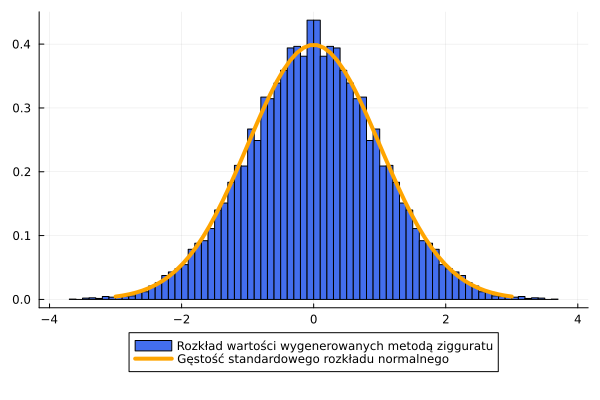

In [216]:
samples = vcat(abs_norm_samples, -abs_norm_samples)
xs = LinRange(-3, 3, 60)
kern = kde(samples)

histogram(samples, normalize=:pdf, label="Rozkład wartości wygenerowanych metodą zigguratu", color=:royalblue1, legend=:outerbottom)
plot!(xs, pdf.(Normal(0, 1), xs), label="Gęstość standardowego rozkładu normalnego", lw=4, color=:orange)

In [211]:
ExactOneSampleKSTest(samples, Normal(0, 1))

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00612434

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.4412

Details:
    number of observations:   20000


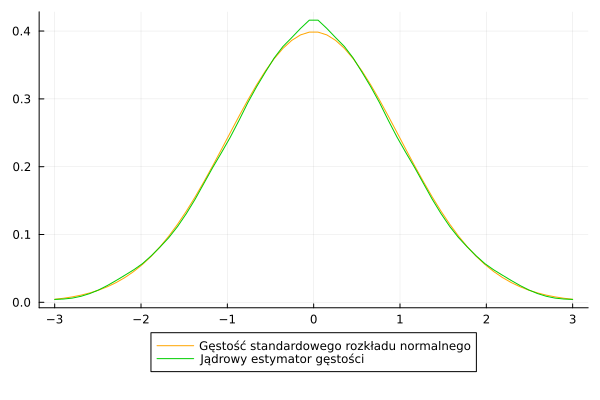

In [210]:
plot(xs, pdf.(Normal(0, 1), xs), label="Gęstość standardowego rozkładu normalnego", color=:orange, legend=:outerbottom)
plot!(xs, pdf(kern, xs), label="Jądrowy estymator gęstości", color=:green3)

---

**Zadanie 4**   

Porównanie różnych metod generowania rozkładu normalnego